In [93]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [146]:
'''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

batch_size = 128
nb_classes = 10
nb_epoch = 1

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 3
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
# model.add(Activation('relu'))
convout1 = Activation('relu')
model.add(convout1)

model.add(Convolution2D(1, nb_conv, nb_conv))
model.add(Activation('relu'))

mp_layer = MaxPooling2D(pool_size=(nb_pool, nb_pool)) 
model.add(mp_layer)
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 15s - loss: 0.9669 - acc: 0.6788 - val_loss: 0.3479 - val_acc: 0.9060
Test score: 0.347882450628
Test accuracy: 0.906


In [147]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_35 (Convolution2D) (None, 3, 26, 26)     30          convolution2d_input_15[0][0]     
____________________________________________________________________________________________________
activation_49 (Activation)       (None, 3, 26, 26)     0           convolution2d_35[0][0]           
____________________________________________________________________________________________________
convolution2d_36 (Convolution2D) (None, 1, 24, 24)     28          activation_49[0][0]              
____________________________________________________________________________________________________
activation_50 (Activation)       (None, 1, 24, 24)     0           convolution2d_36[0][0]           
___________________________________________________________________________________________

# manually compute convolution with the weights from layers

In [159]:
l0_w = model.layers[0].get_weights()
print(l0_w[0][1][0])

[[-0.30937243 -0.09100599  0.10847437]
 [-0.25775579  0.44095528  0.0092474 ]
 [ 0.32412568  0.29409668 -0.08784341]]


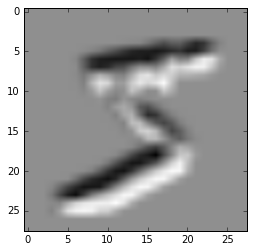

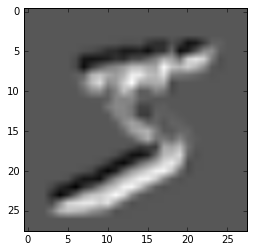

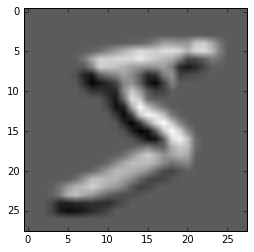

In [182]:
from scipy import ndimage
(sX_train, sy_train), (sX_test, sy_test) = mnist.load_data()

sX_train = sX_train.astype('float32')
sX_train /= 255

l0_w = model.layers[0].get_weights()
l0_0_im = ndimage.convolve(sX_train[0], l0_w[0][0][0], mode='constant', cval=0.0)
l0_1_im = ndimage.convolve(sX_train[0], l0_w[0][1][0], mode='constant', cval=0.0)
l0_2_im = ndimage.convolve(sX_train[0], l0_w[0][2][0], mode='constant', cval=0.0)

sX_train *= 255

plt.figure()
plt.imshow(l0_0_im,cmap='gray')

plt.figure()
plt.imshow(l0_1_im,cmap='gray')

plt.figure()
plt.imshow(l0_2_im,cmap='gray')

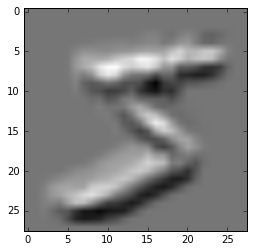

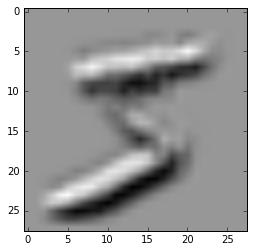

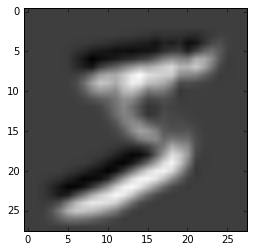

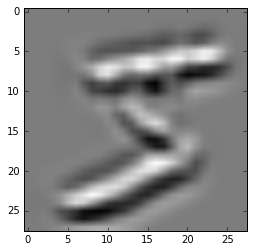

In [183]:
l2_w = model.layers[2].get_weights()
for i in range(l2_w[0].shape[0]):
    for j in range(l2_w[0].shape[1]):
        if j == 0:
            im_conv = ndimage.convolve(l0_0_im, l2_w[0][i][j], mode='constant', cval=0.0)
        else:
            im_conv = ndimage.convolve(l0_1_im, l2_w[0][i][j], mode='constant', cval=0.0)
        plt.figure()
        plt.imshow(im_conv,cmap='gray')
imsum = l0_0_im
for i in range(3):
    imsum += ndimage.convolve(l0_0_im, l2_w[0][0][i], mode='constant', cval=0.0)
imsum /= 3
plt.figure()
plt.imshow(imsum, cmap='gray')

# Weight from model.layers

In [175]:
from keras import backend as K

# with a Sequential model
get_2nd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])

get_0_layer_output = K.function([model.layers[0].input],
                                  [model.layers[0].output])

get_2nd_layer_output([X_train])[0][0].shape

(1, 24, 24)

In [176]:
im_0_layer = get_0_layer_output([X_train])[0][0]*255
im_2nd_layer = get_2nd_layer_output([X_train])[0][0]*255

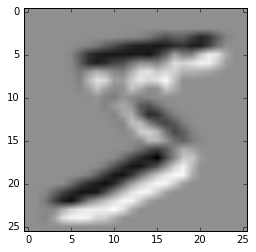

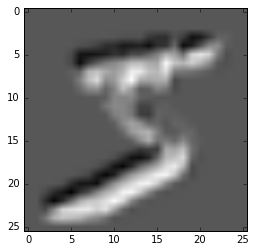

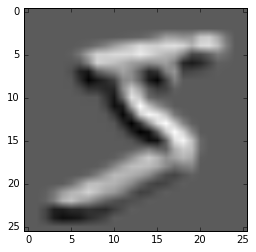

In [177]:
for each_im in im_0_layer:
    plt.figure()
    plt.imshow(each_im, cmap='gray')

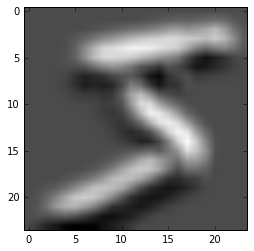

In [178]:
for each_im in im_2nd_layer:
    plt.figure()
    plt.imshow(each_im,cmap='gray')